In [22]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import gc
import random

import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings(action='ignore')

from pycaret.classification import *

import random as python_random
np.random.seed(42)
python_random.seed(42)
set_config('seed', 42)

In [2]:
PATH = './data/'

train_err  = pd.read_csv(PATH+'train_err_data.csv')
train_qua = pd.read_csv(PATH+'train_quality_data.csv')
train_prob = pd.read_csv(PATH+'train_problem_data.csv')

test_err  = pd.read_csv(PATH+'test_err_data.csv')
test_qua  = pd.read_csv(PATH+'test_quality_data.csv')

sample_submssion = pd.read_csv(PATH+'sample_submission.csv')

In [3]:
train_err['date'] = train_err['time'].astype(str).str.slice(0,8)
train_err['model_fwver'] = train_err.model_nm + train_err.fwver
train_err['errtype_code'] = train_err.errtype.astype(str) + train_err.errcode

train_err_0 = train_err[['user_id','date','model_fwver','errtype_code']].drop_duplicates()
display(train_err_0.head())

test_err['date'] = test_err['time'].astype(str).str.slice(0,8)
test_err['model_fwver'] = test_err.model_nm + test_err.fwver
test_err['errtype_code'] = test_err.errtype.astype(str) + test_err.errcode

test_err_0 = test_err[['user_id','date','model_fwver','errtype_code']].drop_duplicates()
display(test_err_0.head())

,user_id,date,model_fwver,errtype_code
0,10000,20201101,model_305.15.2138,151
1,10000,20201101,model_305.15.2138,121
2,10000,20201101,model_305.15.2138,111
3,10000,20201101,model_305.15.2138,161
4,10000,20201101,model_305.15.2138,40


,user_id,date,model_fwver,errtype_code
0,30000,20201101,model_104.16.3553,311
1,30000,20201101,model_104.16.3553,332
2,30000,20201101,model_104.16.3553,151
3,30000,20201101,model_104.16.3553,221
4,30000,20201101,model_104.16.3553,111


In [4]:
train_err.shape, train_err_0.shape

((16554663, 9), (3480961, 4))

In [5]:
train_err_1 = train_err.groupby(['user_id','date']).count().reset_index()[['user_id','date','time']]
train_err_1.columns = ['user_id','date','date_cnt']
train_err_1 = train_err_1.groupby('user_id').agg({'date':'count','date_cnt': 'sum'}).reset_index()
train_err_1.columns = ['user_id','date_cnt', 'date_sum']
display(train_err_1.head())

test_err_1 = test_err.groupby(['user_id','date']).count().reset_index()[['user_id','date','time']]
test_err_1.columns = ['user_id','date','date_cnt']
test_err_1 = test_err_1.groupby('user_id').agg({'date':'count','date_cnt': 'sum'}).reset_index()
test_err_1.columns = ['user_id','date_cnt', 'date_sum']
display(test_err_1.head())

train_err_1.shape

,user_id,date_cnt,date_sum
0,10000,30,317
1,10001,30,2365
2,10002,29,306
3,10003,30,306
4,10004,30,777


,user_id,date_cnt,date_sum
0,30000,29,2750
1,30001,28,284
2,30002,30,941
3,30003,28,371
4,30004,30,881


(15000, 3)

In [6]:
train_err_2 = train_err.groupby('model_fwver').count().reset_index()[['model_fwver','user_id']]
train_err_2.columns = ['model_fwver','model_fwver_cnt']
train_err_2['model_fwver_rank'] = train_err_2.model_fwver_cnt.rank()
display(train_err_2.head())

test_err_2 = test_err.groupby('model_fwver').count().reset_index()[['model_fwver','user_id']]
test_err_2.columns = ['model_fwver','model_fwver_cnt']
test_err_2['model_fwver_rank'] = test_err_2.model_fwver_cnt.rank()
display(test_err_2.head())

,model_fwver,model_fwver_cnt,model_fwver_rank
0,model_004.22.1442,2522,21.0
1,model_004.22.1656,39,7.0
2,model_004.22.1666,5,1.0
3,model_004.22.1684,5554,25.0
4,model_004.22.1750,2874213,36.0


,model_fwver,model_fwver_cnt,model_fwver_rank
0,model_004.22.1170,817,18.0
1,model_004.22.1448,840,21.0
2,model_004.22.1478,535,15.0
3,model_004.22.1608,12,2.0
4,model_004.22.1656,835,19.0


In [7]:
# train_err > errtype_code => rank
train_err_3 = train_err.groupby('errtype_code').count().reset_index()[['errtype_code','user_id']]
train_err_3.columns = ['errtype_code','errtype_code_cnt']
train_err_3['errtype_code_rank'] = train_err_3.errtype_code_cnt.rank()
display(train_err_3.head())

# test_err > errtype_code => rank
test_err_3 = test_err.groupby('errtype_code').count().reset_index()[['errtype_code','user_id']]
test_err_3.columns = ['errtype_code','errtype_code_cnt']
test_err_3['errtype_code_rank'] = test_err_3.errtype_code_cnt.rank()
display(test_err_3.head())

,errtype_code,errtype_code_cnt,errtype_code_rank
0,10,21079,2825.0
1,101,133403,2851.0
2,111,307030,2854.0
3,121,320181,2855.0
4,131,22843,2828.0


,errtype_code,errtype_code_cnt,errtype_code_rank
0,10,21381,2980.0
1,101,149008,3002.0
2,111,327050,3008.0
3,121,304129,3005.0
4,131,13944,2974.0


In [36]:
train = train_err.merge(train_err_1, on=['user_id'], how='left').merge(train_err_2, on='model_fwver', how='left').merge(train_err_3, on='errtype_code', how='left')
train = train[['user_id','date_cnt','date_sum','model_fwver_rank','errtype_code_rank']].drop_duplicates()
train = train.groupby(['user_id','date_cnt','date_sum']).agg({'model_fwver_rank':['count', 'max'],'errtype_code_rank':['max']}).reset_index()
train.columns = ['user_id','date_cnt','date_sum','model_fwver_cnt','model_fwver_max','errtype_code_max']
train

,user_id,date_cnt,date_sum,model_fwver_cnt,model_fwver_max,errtype_code_max
0,10000,30,317,15,34.0,2868.0
1,10001,30,2365,46,35.0,2870.0
2,10002,29,306,17,34.0,2868.0
3,10003,30,306,36,35.0,2870.0
4,10004,30,777,36,36.0,2870.0
...,...,...,...,...,...,...
14995,24995,10,194,22,35.0,2870.0
14996,24996,1,4,4,34.0,2860.0
14997,24997,30,826,44,36.0,2870.0
14998,24998,21,155,24,36.0,2870.0


In [37]:
test = test_err.merge(test_err_1, on=['user_id'], how='left').merge(test_err_2, on='model_fwver', how='left').merge(test_err_3, on='errtype_code', how='left')
test = test[['user_id','date_cnt','date_sum','model_fwver_rank','errtype_code_rank']].drop_duplicates()
test = test.groupby(['user_id','date_cnt','date_sum']).agg({'model_fwver_rank':['count', 'max'],'errtype_code_rank':[ 'max']}).reset_index()
test.columns = ['user_id','date_cnt','date_sum','model_fwver_cnt','model_fwver_max','errtype_code_max']
test

,user_id,date_cnt,date_sum,model_fwver_cnt,model_fwver_max,errtype_code_max
0,30000,29,2750,69,40.0,3021.0
1,30001,28,284,15,37.0,3019.0
2,30002,30,941,42,39.0,3021.0
3,30003,28,371,51,39.0,3021.0
4,30004,30,881,49,40.0,3021.0
...,...,...,...,...,...,...
14993,44994,30,1115,25,40.0,3021.0
14994,44995,30,515,27,39.0,3019.0
14995,44996,30,2233,44,39.0,3021.0
14996,44997,28,24671,49,39.0,3021.0


In [10]:
train_qua_0 = train_qua.drop_duplicates()
test_qua_0 = test_qua.drop_duplicates()

train_qua_0.drop(['quality_3','quality_4','time','fwver'], axis=1, inplace=True)
test_qua_0.drop(['quality_3','quality_4','time','fwver'], axis=1, inplace=True)

train_qua_0.fillna(0, inplace=True)
test_qua_0.fillna(0, inplace=True)

In [11]:
def chg_qua(x):
    if x == 0:
        return 0
    else:
        return 1

In [12]:
cols = ['quality_0', 'quality_1', 'quality_2', 'quality_5','quality_6', 'quality_7', 'quality_8', 'quality_9', 'quality_10','quality_11', 'quality_12']

for col in cols:
    train_qua_0[col] = train_qua_0[col].apply(chg_qua)
    test_qua_0[col] = test_qua_0[col].apply(chg_qua)

In [13]:
train_qua_1 = train_qua_0.groupby('user_id').sum().reset_index()
test_qua_1 = test_qua_0.groupby('user_id').sum().reset_index()

In [14]:
%%time
for col in cols:
    train_qua_1[col] = train_qua_1[col].apply(chg_qua)
    test_qua_1[col] = test_qua_1[col].apply(chg_qua)

Wall time: 53 ms


In [38]:
train = train.merge(train_qua_1, on='user_id', how='left').fillna(0)
test = test.merge(test_qua_1, on='user_id', how='left').fillna(0)

In [16]:
train_prob1 = train_prob.groupby('user_id').count().reset_index()
train_prob1.time = train_prob1.time.apply(chg_qua)
train_prob1.columns = ['user_id', 'prob']
train_prob1

,user_id,prob
0,10001,1
1,10004,1
2,10005,1
3,10006,1
4,10008,1
...,...,...
4995,24983,1
4996,24984,1
4997,24990,1
4998,24997,1


In [39]:
train = train.merge(train_prob1, on='user_id', how='left').fillna(0)

In [40]:
display(train.head())
display(test.head())

,user_id,date_cnt,date_sum,model_fwver_cnt,model_fwver_max,errtype_code_max,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12,prob
0,10000,30,317,15,34.0,2868.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,10001,30,2365,46,35.0,2870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,10002,29,306,17,34.0,2868.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
3,10003,30,306,36,35.0,2870.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10004,30,777,36,36.0,2870.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


,user_id,date_cnt,date_sum,model_fwver_cnt,model_fwver_max,errtype_code_max,quality_0,quality_1,quality_2,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,30000,29,2750,69,40.0,3021.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,30001,28,284,15,37.0,3019.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,30002,30,941,42,39.0,3021.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,30003,28,371,51,39.0,3021.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
4,30004,30,881,49,40.0,3021.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0


In [41]:
train.shape, test.shape

((15000, 18), (14998, 17))

In [44]:
col = ['quality_1','quality_2']
train.drop(col, axis=1,inplace=True)
test.drop(col, axis=1, inplace=True)

In [46]:
col = ['quality_11']
train.drop(col, axis=1,inplace=True)
test.drop(col, axis=1, inplace=True)

In [48]:
col = ['quality_6']
train.drop(col, axis=1,inplace=True)
test.drop(col, axis=1, inplace=True)

In [50]:
col = ['quality_5']
train.drop(col, axis=1,inplace=True)
test.drop(col, axis=1, inplace=True)

In [52]:
col = ['quality_10']
train.drop(col, axis=1,inplace=True)
test.drop(col, axis=1, inplace=True)

In [54]:
col = ['quality_9']
train.drop(col, axis=1,inplace=True)
test.drop(col, axis=1, inplace=True)

<AxesSubplot:>

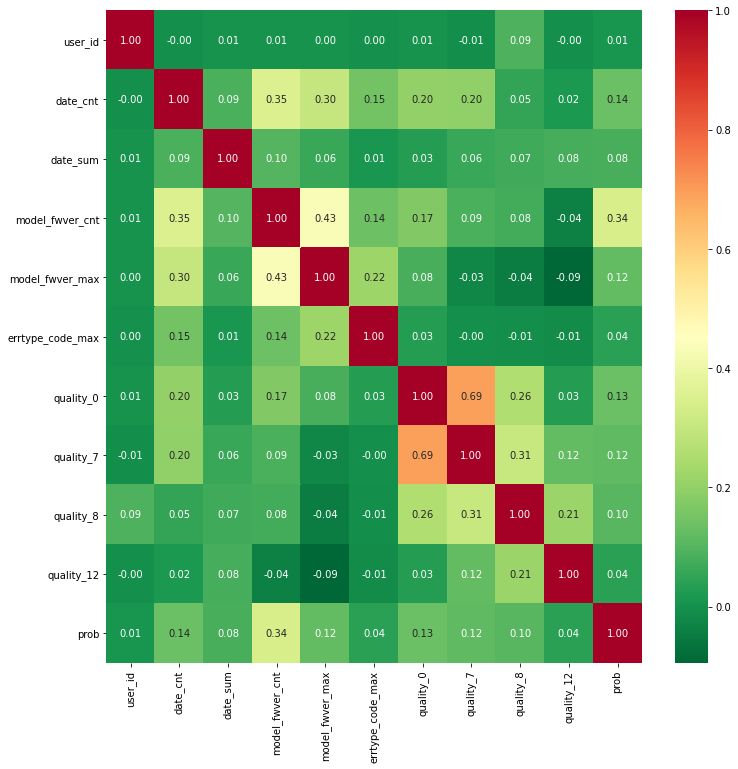

In [55]:
plt.figure(figsize=(12,12))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap='RdYlGn_r')

In [ ]:
test.columns

In [56]:
cols = ['date_cnt', 'date_sum', 'model_fwver_cnt', 'model_fwver_max','errtype_code_max']

In [57]:
min = train[cols].min()
max  = train[cols].max()

In [58]:
for i, col in enumerate(cols):
    train[col] = (train[col] - min[i]) / (max[i] - min[i])
    test[col] = (test[col] - min[i]) / (max[i] - min[i])

In [59]:
train.prob = train.prob.astype(int)

In [60]:
%%time
clf = setup(session_id=42, data=train, target='prob')

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(15000, 11)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,4
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 14.5 s


In [61]:
best = compare_models(sort = 'AUC', n_select = 5
                     ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                     )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.7340,0.7480,0.3883,0.6749,0.4927,0.3300,0.3532,0.6163
1,CatBoost Classifier,0.7326,0.7468,0.4009,0.6632,0.4993,0.3320,0.3517,7.6680
2,Ada Boost Classifier,0.7260,0.7393,0.3946,0.6458,0.4896,0.3170,0.3351,0.2418
3,Light Gradient Boosting Machine,0.7302,0.7392,0.4040,0.6536,0.4990,0.3284,0.3463,0.1943
4,Extreme Gradient Boosting,0.7224,0.7302,0.4089,0.6284,0.4950,0.3154,0.3294,0.4845
5,Linear Discriminant Analysis,0.7237,0.7132,0.3343,0.6720,0.4461,0.2889,0.3202,0.0330
6,Random Forest Classifier,0.6800,0.6686,0.4029,0.5261,0.4561,0.2351,0.2394,0.1227
7,Extra Trees Classifier,0.6704,0.6664,0.4589,0.5063,0.4811,0.2406,0.2414,0.2963


In [62]:
blended = blend_models(estimator_list = best, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7243,0.7306,0.3986,0.6384,0.4908,0.3153,0.3318
1,0.7557,0.7636,0.4300,0.7253,0.5399,0.3881,0.4126
2,0.7371,0.7458,0.4114,0.6729,0.5106,0.3449,0.3644
3,0.7348,0.7497,0.3886,0.6783,0.4941,0.3319,0.3555
4,0.7189,0.7296,0.3714,0.6341,0.4685,0.2947,0.3142
Mean,0.7342,0.7439,0.4000,0.6698,0.5008,0.3350,0.3557
SD,0.0127,0.0127,0.0199,0.0329,0.0237,0.0314,0.0335


In [63]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7347,0.7468,0.398,0.6723,0.5,0.3352,0.3566


In [64]:
%%time
final_model = finalize_model(blended)

Wall time: 1min 53s


In [65]:
test_x = sample_submssion[['user_id']].merge(test, on='user_id', how='left').fillna(0)
test_x.shape

(14999, 10)

In [66]:
predictions = predict_model(final_model, data = test_x)

In [67]:
sample_submssion['problem'] = predictions['Score']
sample_submssion.head()

,user_id,problem
0,30000,0.6592
1,30001,0.1842
2,30002,0.6280
3,30003,0.7528
4,30004,0.7208


In [68]:
sample_submssion.to_csv("./submission/submission_20210126-5.csv", index = False)
sample_submssion

,user_id,problem
0,30000,0.6592
1,30001,0.1842
2,30002,0.6280
3,30003,0.7528
4,30004,0.7208
...,...,...
14994,44994,0.3711
14995,44995,0.3760
14996,44996,0.6142
14997,44997,0.8027
